#Installing necessary modules

In [ ]:
%%shell

cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF


apt-get update
apt-get install chromium chromium-driver

pip install selenium


Executing: /tmp/apt-key-gpghome.AALoUXzVHm/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
gpg: key DCC9EFBF77E11517: public key "Debian Stable Release Key (10/buster) <debian-release@lists.debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Executing: /tmp/apt-key-gpghome.UHL4xX6E9V/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
gpg: key DC30D7C23CBBABEE: public key "Debian Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Executing: /tmp/apt-key-gpghome.CjxIz0j7zu/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A
gpg: key 4DFAB270CAA96DFA: public key "Debian Security Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Get:1 http://deb.debian.org/debian buster InRelease [122 kB]
Get:2 http://security.ubuntu.com/ubuntu

#Function to extract data from UNT faculty info page <br> https://facultyinfo.unt.edu/

In [ ]:
import requests
from bs4 import BeautifulSoup


def extract_data(url):
  response = requests.get(url)
  prof_links=[]
  all_data=[]
  if response.status_code == 200:

      soup = BeautifulSoup(response.text, 'html.parser')


      fis_links = soup.find_all('a', class_='fis-link')

      href_links = [a.get('href') for a in fis_links]

      for index in range(0, len(href_links), 3):
          prof_links.append(href_links[index])

  else:
      print(f"Failed to retrieve data: {response.status_code}")

  for i, url in enumerate(prof_links):
    profile=[]
    prof_det=[]
    profile_id = url.split('profile=')[-1]
    full_url = f"https://facultyinfo.unt.edu{url}#previous-teaching"
    profile=[]
    prof_det=[]
    response = requests.get(full_url)
    if response.status_code == 200:

      soup = BeautifulSoup(response.text, 'html.parser')
      name = soup.find('div', id='profile-name')
      dep = soup.find('div', id='profile-department')
      publications_div = soup.find('div', id='tab-publications')
      current_teachings = soup.find('div', id='tab-current-teaching')

      if publications_div:
        list_items = publications_div.find_all('li')
        if len(list_items)==0:
          publications=''
        else:
          publications = [item.get_text().strip() for item in list_items]
      else:
        print('publications not found')

      if name:
          profile_name = name.get_text(strip=True)
          profile.append(profile_name)
      else:
          print("Profile name not found.")

      if dep:
          p_tags = dep.find_all('p')

          for p in p_tags:
              text = p.get_text(strip=True)
              profile.append(text)
          prof_det.append(profile)
          profile=[]
      else:
          print("Profile department div not found.")
      teaching_div = soup.find('div', id='tab-previous-teaching')
      table = teaching_div.find('table')
      if table:
        rows = table.find_all('tr')
        data = []
        for row in rows:
            cells = row.find_all('td')
            course_code = cells[0].text.strip()
            course_title = cells[1].text.strip()
            semester = cells[2].text.strip()

            spot_link = cells[4].find('a')

            if spot_link:
              spot_overall = spot_link['data-spot-overall']
              spot_responses = spot_link['data-spot-responses']
              spot_students = spot_link['data-spot-students']
              data_spot_cei = spot_link['data-spot-cei']
              spot_eid = spot_link['data-spot-eid']
            else:
              spot_overall = ''
              spot_responses = ''
              spot_students = ''
              data_spot_cei = ''
              spot_eid = ''

            data.append((course_code, course_title, semester,spot_eid ,spot_overall, spot_responses, spot_students,data_spot_cei,publications,profile_id))
            combined_details = [prof_det[0] + list(course) for course in data]
        all_data.append(combined_details)
      else:
        data=[]
        data.append(('', '', '','' ,'', '', '',''))
        combined_details = [prof_det[0] + list(course) for course in data]
        all_data.append(combined_details)

      if current_teachings:
        teaching_rows = current_teachings.find('table', class_='profile-courses-table')
        if teaching_rows:

          teaching_data = []

          for row in teaching_rows:
            if row.name == 'tr':
              columns = row.find_all('td')
              course_info = [col.get_text(strip=True) for col in columns]
              teaching_data.append(course_info)
          for course in teaching_data:

            data=[]
            data.append((course[0], course[1], course[2], '', '', '','','',publications,profile_id))
            combined_details = [prof_det[0] + list(course) for course in data]
            all_data.append(combined_details)

        else:
          #print('teachings table not found')
          ''
      else:
        #print('curr teachings not found')
        ''
    else:
      print(f"Failed to retrieve data: {response.status_code}")

  flattened_data = [item for sublist in all_data for item in sublist]

  return flattened_data


In [ ]:
urls = [
    "https://facultyinfo.unt.edu/faculty-search?dept=Information%20Science"
]

complete_data =[]

for url in urls:
  complete_data.extend(extract_data(url))


In [ ]:
import pandas as pd

df = pd.DataFrame(complete_data, columns=['name', 'title', 'dept', 'college','course','course name','semester','eid','Overall Summative Rating','no of responses','no of students','Challenge and Engagement Index','pub','profile id'])


#Extracting data from UNT expert portal <br> https://experts.unt.edu/

In [ ]:
import time
from selenium import webdriver
from bs4 import BeautifulSoup
from selenium.webdriver.chrome.options import Options
chrome_options = Options()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
wd = webdriver.Chrome(options=chrome_options)

url = "https://experts.unt.edu/expert-search?query=%2C+"
wd.get(url)

time.sleep(5)

html = wd.page_source

soup = BeautifulSoup(html, 'html.parser')

faculty_members = soup.find_all("div", class_="results-result")
print(f"Number of faculty members found: {len(faculty_members)}")

data = []
for member in faculty_members:
    name = member.find("h1", class_="result-name").get_text(strip=True)
    department = member.find("span", class_="result-department").get_text(strip=True) if member.find("span", class_="result-department") else ""
    college = member.find("span", class_="result-college").get_text(strip=True) if member.find("span", class_="result-college") else ""
    degrees = [degree.get_text(strip=True) for degree in member.find_all("span", class_="result-degrees")]
    keywords = member.find("ul", class_="result-keywords").get_text(strip=True).split(', ') if member.find("ul", class_="result-keywords") else []
    profile_link = member.find("a", class_="fis-link")['href'].split('profile=')[-1] if member.find("a", class_="fis-link") else ""

    data.append({
        "Name": name,
        "Department": department,
        "College": college,
        "Degrees": degrees,
        "Keywords": keywords,
        "profile id": profile_link
    })

print(f"Number of faculty members found: {len(faculty_members)}")


wd.quit()


Number of faculty members found: 849
Number of faculty members found: 849


In [ ]:
df_r = pd.DataFrame(data)

#Merging data from faculty and expert portals

In [ ]:
merged_df = pd.merge(df, df_r[['profile id', 'Keywords']], on='profile id', how='left')

In [ ]:
merged_df = merged_df[['name','title','dept','course','semester','Overall Summative Rating',	'no of responses','no of students','Challenge and Engagement Index','pub','Keywords','profile id']]

In [ ]:
merged_df.head()

,name,title,dept,course,semester,Overall Summative Rating,no of responses,no of students,Challenge and Engagement Index,pub,Keywords,profile id
0,Daniel Agbaji,Title:Teaching Fellow,Department:Information Science,INFO 5810.003,Fall 2023,4.7,43,44,6.5,,NaN,daa0194
1,Daniel Agbaji,Title:Teaching Fellow,Department:Information Science,INFO 5810.003,Spring 2023,4.7,82,84,6.6,,NaN,daa0194
2,Daniel Agbaji,Title:Teaching Fellow,Department:Information Science,INFO 5810.601,Spring 2023,4.7,82,84,6.6,,NaN,daa0194
3,Mohammed Aledhari,Title:Assistant Professor,Department:Information Science,DTSC 5505.002,Summer 10W 2024,4.8,27,61,6.8,"[Aledhari, M., Razzak, R., Parizi, R.M., Sriva...","[Artificial intelligence, machine learning, da...",ma1603
4,Mohammed Aledhari,Title:Assistant Professor,Department:Information Science,INFO 5505.001,Spring 2024,4.9,43,90,6.6,"[Aledhari, M., Razzak, R., Parizi, R.M., Sriva...","[Artificial intelligence, machine learning, da...",ma1603


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7077 entries, 0 to 7076
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   name                            7077 non-null   object
 1   title                           7077 non-null   object
 2   dept                            7077 non-null   object
 3   course                          7077 non-null   object
 4   semester                        7077 non-null   object
 5   Overall Summative Rating        7077 non-null   object
 6   no of responses                 7077 non-null   object
 7   no of students                  7077 non-null   object
 8   Challenge and Engagement Index  7077 non-null   object
 9   pub                             7068 non-null   object
 10  Keywords                        2804 non-null   object
 11  profile id                      7068 non-null   object
dtypes: object(12)
memory usage: 663.6+ KB


In [ ]:
merged_df.shape

(7077, 12)

In [ ]:
numeric_cols = ["Overall Summative Rating", "no of responses", "no of students", "Challenge and Engagement Index"]
for col in numeric_cols:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')


#Finding missing values

In [ ]:
merged_df.isna().sum()

,0
name,0
title,0
dept,0
course,0
semester,0
Overall Summative Rating,4329
no of responses,4311
no of students,4311
Challenge and Engagement Index,4330
pub,9


In [ ]:
len(merged_df[merged_df['pub'].apply(lambda x: x == '')]['name'].unique())

55

# Missing value imputation

In [ ]:
mean_values = merged_df.groupby("name").mean(numeric_only=True)


In [ ]:
mean_values = merged_df.groupby("name").mean(numeric_only=True)

df_imputed = merged_df.copy()

for col in ["Overall Summative Rating", "no of responses", "no of students", "Challenge and Engagement Index"]:
    df_imputed[col] = df_imputed.apply(lambda row: mean_values.loc[row["name"], col]
                                       if pd.isna(row[col]) else row[col], axis=1)



In [ ]:
pub_impute_data = {
    'daa0194' : '[Mannuru, N. R., Shahriar, S., Teel, Z. A., Wang, T., Lund, B. D., Tijani, S., ... & Vaidya, P. (2023). Artificial intelligence in developing countries: The impact of generative artificial intelligence (AI) technologies for development. Information Development, 02666669231200628.Lund, B. D., Omame, I., Tijani, S., & Agbaji, D. (2020). Perceptions toward artificial intelligence among academic library employees and alignment with the diffusion of innovations’ adopter categories. College & Research Libraries, 81(5), 865.Lund, B., Agbaji, D., & Teel, Z. A. (2023). Information literacy, data literacy, privacy literacy, and chatgpt: Technology literacies align with perspectives on emerging technology adoption within communities. Lund, B., Agbaji, D., & Teel, ZA (2023). Information literacy, data literacy, privacy literacy, and ChatGPT: Technology literacies align with perspectives on emerging technology adoption within communities. Human Technology, 19(2), 163-177.Lund, B. D., & Agbaji, D. A. (2018). Augmented reality for browsing physical collections in academic libraries. Public Services Quarterly, 14(3), 275-282.Lund, B., Agbaji, D., Tijani, S., & Omame, I. (2019). Evaluating knowledge organization in developed and developing countries: A comparative analysis of Dewey Decimal and library of congress classification scheme preference and use in the united states and Nigeria. Technical Services Quarterly, 36(3), 249-268.]',
    'mta0088' : '[Buchanan, S.A. (Panelist), Alsaid, M. (Panelist), Harris, R. (Panelist), Hawamdeh, S.M. (Panelist), Herr, J. (Panelist), Kouper, I. (Panelist), Association for Library and Information Science Education Annual Meeting, Translating Practice to Positively Transform our Information Workforce, Association for Library and Information Science Education, Milwaukee, Wisconsin, United Kingdom. (2023 - 2023).]',
    'ams0325' : '[RURAL HOSPICE SOCIAL WORK: SUPPORTING PRACTITIONERS IN END-OF-LIFE WORK WITH LIMITED RESOURCES B Felderhoff, A Alvarado, V Alvarez Innovation in Aging 6 (Supplement_1), 43-43. Developing Culturally Competent and Emotionally Intelligent Social Work Leaders GB Bailey, C Crow Cruz, A Mallow, A A AdvanceResearch in Psychology and Behavioural Sciences (ARPBS) 1 (1) Information Seeking Behaviors of Medical Professionals A Alvarado, MS-IS, MS, LBSW-IPR, APHSW-C Journal of Advancements in Applied Business Research 11 (3), 86-94 Emotionally Intelligent and Culturally Competent Social Work Leaders GB Bailey, CC Cruz, DSW Alissa Mallow, LRA Alvarado, AC LBSW-IPR]',
    'aa0460'  : '[Awojobi, A., & Chang, H. C. (2017). Security and privacy issues with smart thermostats–A first look. Awojobi, A. (2020). User Privacy Perception and Concerns Regarding the Use of Cloud-Based Assistants.]',
    'tjb0028' : '[Faculty-Librarian Collaboration for Library Services in the Online Classroom: Student Evaluation Results and Recommended Practices for Implementation. Journal of Library & Information Services in Distance Education 3(2):67-102. With Elizabeth Figa and Janet Macpherson. Librarian on Board! Online Classroom Library Services to Distance E-Learning Students: A Service Analysis Using Survey and Interview Research Techniques. Texas Library Journal 85(1):14-19. With Elizabeth Figa. The GUI as Cultural Artifact: It’s Role in Perpetuating the Status Quo. Information Systems Education Journal 5(10). http://isedj.org/5/10/. Factors in the Settlement and Growth of Weatherford, Texas. The Tarleton Freshman Writer XIII:159-168.]',
    'ab0771'  : '[Bukhari, A., Alqahtani, S., Alharbi, M., Almalki, A., & Bukhari, M. Impact of Teaching Adolescents Social Engineering on Social Media. Bukhari, A., & Alazemi, M. Using Social Media Tools to Share a Knowledge in Organizations or Institutions. Bukhari, M. A. A. (2022). How Can Social Media Platforms Help Improve Middle School Library Services in Kuwait?. Journal of Education and Human Development, 11(3), 41-52.]',
    'mkb0256' : '[Kim, J., Roeschley, A., & Byun, M. (2024). Building bridges and preserving voices: key factors in community oral history stewardship. Journal of Documentation, 80(6), 1458-1474. Byun, M., Evans, S., Herman, B., Aragon, C., & Rojas‐Ponce, D. (2022). Game Development as Speculative Design: Teaching Data Science Ethics Using Decentralized Research Groups. Proceedings of the Association for Information Science and Technology, 59(1), 630-632.]',
    'dlc0069' : '[How to Research Corporate Governance Issues, Information Outlook, January 2005, p.15-17 Market the Value of Your Competitive Intelligence: An Added Role for the Information Center, Information Outlook, February 2000, 32-35 Hide And Seek: Searching For Advanced Company Information, Information Outlook, January 1997, p.26-28]',
    'dlc0267' : '[Smith, D. L., Milburn, S. M., Esener, Y., & Colby, D. (2022). Teachers Perceptions of One-to-One Laptop Implementation: Suggestions for the Role of School Librarians. School Library Research, 25. Smith, D., Milburn, S., Colby, D., Esener, Y., & Gill, D. (2021, September). What is Important for Survival?: The Analysis of a School Librarians COVID-19 Blog Post Corpus. In IASL Annual Conference Proceedings.]',
    'msc0274' : '[Collins, M. S. (1995). Rhetoric, household and cosmos: A rhetorical and sociological analysis of the letter to the colossians with particular focus on colossians 3:18-4:1 (Order No. 9528967). Available from ProQuest Dissertations & Theses Global; ProQuest One Literature. (304231823). Retrieved from https://libproxy.library.unt.edu/login?url=https://www.proquest.com/dissertations-theses/rhetoric-household-cosmos-rhetorical-sociological/docview/304231823/se-2. Collins, M. S. (2020). Thrust faults bound an elevated mantle plug beneath several lunar basins (Order No. 28122847). Available from ProQuest Dissertations & Theses Global. (2478025811). Retrieved from https://libproxy.library.unt.edu/login?url=https://www.proquest.com/dissertations-theses/thrust-faults-bound-elevated-mantle-plug-beneath/docview/2478025811/se-2. Collins, M. S., Hertzberg, J. E., Mekik, F., & Schmidt, M. W. (2017). A new multi-basin calibration for estimating paleo-temperature using Mg/Ca from tests of neogloboquadrina dutertrei. American Geophysical Union Fall Meeting, 2017, Abstract PP33B-2322. Retrieved from https://libproxy.library.unt.edu/login?url=https://www.proquest.com/scholarly-journals/new-multi-basin-calibration-estimating-paleo/docview/2368503194/se-2]',
    'sic0026' : '[Coronado, S. (2019). Rights in the time of populism: land and institutional change amid the reemergence of right-wing authoritarianism in Colombia. Land, 8(8), 119. Coronado, S., & Zampunieris, D. (2010, April). Continuous proactivity in learning management systems. In IEEE EDUCON 2010 Conference (pp. 199-204). IEEE.]',
    'cac0048' : '[no publications]',
    'smd0191' : '[Shankle, B., Dodd, S., & Downing, J. G. (2017). Advocates for Disability Rights: Building the Texas Disability History Collection.]',
    'cmd0148' : '[no publications]',


    'jy0282'  : '[H. Zhang, A. Yang, A. Peng, L. F. Pieptea, J. Yang and J. Ding, "A Quantitative Study of Software Reviews Using Content Analysis Methods," in IEEE Access, vol. 10, pp. 124663-124672, 2022, doi: 10.1109/ACCESS.2022.3224048.]',
    'ckw0006' : '[no publications]',
    'sfw0046' : '[A Performance Benchmark of the Alpha-Beta Search Procedure on Randomly Ordered, Non-Uniform, Depth-First Game-Trees Generated by a Chess Program” in International Computer Chess Association Journal, volume 10, number 1]',
    'aem0053' : '[no publications]',
    'tw0374'  : '[Early Diagnosis of Children with Neurodevelopment Disorders: A Review of Research with Implications for Applying DSM-5 Diagnostic Criteria to Young Children, Infertility Consumer Health Information and Resources,Challenges that health professionals face to evaluate and trust online health information: the role of conscientiousness,Empowering Parent Caregivers: Libraries and Mobile Health in Rare Disease Information Access]',
    'vv0263'  : '[V. Veluru, T. Xiao, S. Addagudi, S. Kumar and G. Mohanraj, "Machine Learning Optimization Model to Predict Fantasy Basketball Teams," 2024 International Conference on Computing and Data Science (ICCDS), Chennai, India, 2024, pp. 1-4, doi: 10.1109/ICCDS60734.2024.10560397.]',
    'evv0002' : '[Zavalina, O, & Vassilieva, E. (2014). Understanding the Information Needs of Large-Scale Digital Library Users. Library Resources & Technical Services, 58(2), 84-99.,Zavalina, O. L., & Vassilieva, E. V. (2013). Comparative analysis of user searching in domain-specific and domain-independent digital libraries. iConference 2013 Proceedings (pp. 536-542). doi:10.9776/13272,Zavalina, O.L., & Vassilieva, E. (2012). Longitudinal comparative analysis of item-level and collection-level user searching in a digital library. Poster abstract/short paper for the 75th Annual Meeting of the American Society for Information Science and Technology. Baltimore, Maryland.]',
    'ecu0005'  : '[An improved drift-flux correlation for gas-liquid two-phase flow in horizontal and vertical upward inclined wells,Experimental study of single Taylor bubble rising in stagnant and downward flowing non-newtonian fluids in inclined pipes,Computational fluid dynamics simulations of Taylor bubbles rising in vertical and inclined concentric annuli,Experimental and Theoretical Studies on Taylor Bubbles Rising in Stagnant Non-Newtonian Fluids in Inclined Non-Concentric Annuli,Design and Calculation of Process Parameters in Bullheading and Pressurized Mud Cap Drilling]',
    'kjs0171' : '[no publications]',
    'jms0435' : '[Spence, J. M. (2018). A comparison of major factors that affect hospital formulary decision-making by three groups of prescribers (Doctoral dissertation, University of North Texas). Retrieved from:https://digital.library.unt.edu/ark:/67531/metadc1157518/,Spence, J. M., Bui, N., Tran, T., Guevara, B., & Yao, Y. (2015). Decreasing drug transfer times between retail pharmacies – drug trac at MD Anderson Cancer Center. Poster presented at the University of Texas MD Anderson Cancer Center – 2015 Celebrate Improvement, Houston, TX.]',
    'ks0020'  : '[no publications]',
    'lms0029' : '[Exploring Health Literacy and Vascular Access Decision Making: A Scoping Review,Race and gender bias in the research community on African lions]',
    'ls0008'  : '[no publications]',
    'po0132'  : '[Towards developing a data security aware federated training framework in multi-modal contested environments, Tinym2net: A flexible system algorithm co-designed multimodal learning framework for tiny devices,A comprehensive study of gradient inversion attacks in federated learning and baseline defense strategies, Aris: A real-time edge computed accident risk inference system,Mixed quantization enabled federated learning to tackle gradient inversion attacks]',

    'jak0355' : '[no publications]',
    'dak0126' : '[no publications]',
    'tak0124' : '[Smith, D.L. (Principal), Tyler-Wood, T.L. (Co-Principal), Zhang, X. (Co-Principal), Kuon, T.A. (Supporting), Evans, S.A. (Supporting), Schultz-Jones, B.A. (Supporting), Moore, J. (Supporting), "School librarians facilitating the success of English language learners," sponsored by Institute for Museum and Library Science (IMLS), Federal, $132893 Funded. (2021 - 2023).]',
    'hal0007' : '[How Technology Aids Constructivism in the Social Studies Classroom, Social presence within the community of inquiry framework.]',
    'njl0028' : '[Texas Library Journal.]',
    'sml0266' : '[Change in Event Centrality and Posttraumatic Stress Disorder Symptoms During Intensive Treatment, Blurred boundaries between Pro-Anorexia and Fitspiration media? Diverging cognitive and emotional effects, Moral Decision Making, Religious Strain, and the Experience of Moral Injury, Information Technology Management.]',
    'tl0466'  : '[Enhancing usability of digital libraries: Designing help features to support blind and visually impaired users, Zero Trust Cybersecurity: Procedures and Considerations in Context, Accessibility,Multilingual Support in Digital Environments: A Case Study of Online Catalogs in US Public Libraries, with a Focus on Korean-Language Speakers,  Digital Library, Information Behavior, Information Security, User Experience.]',
    'zil0004' : '[Electronic Resources, Literacy, Library Management, Literature,  Library Science]',
    'tdm0119' : '[The American Society for Information Science & Technology (ASIS&T), Vancouver, B.C, McMillan, Tyson (2005). Assessing Educator Perceptions of Attention Deficit Hyperactivity Disorder in a West Texas Community, Information Science, Web Development, Information Policy, Computational Law]',
    'mm3396'  : '[Thrombocytosis and megakaryocyte changes associated with PRCA, Identification of Optimal Time Domain Features for Machine Learning based Fault Classification, Classification of Distributed Bearing Faults using a Novel Sensory Board and Deep Learning Networks with Hybrid Inputs, Machine learning prediction for COVID-19 disease severity at hospital admission, Bioinformatics, Medical Imaging, Machine Learning, Image Processing.]',
    'jnm0106' : '[“They Never Do This to Men”: College Women Athlet’ Responses to Sexualized Images of Professional Women Athletes, research methodologies, information behavior, online course design, media ethics, and health informatics]',
    'sm0140'  : '[The adoption of open source software in Uganda: Analyzing stakeholders and their underlying interests, Clash of the titans: Analyzing the convergence of telephony and radio in the power contest between Ugandas central government and Buganda Kingdom, Coping with Accessibility and Usability Challenges of Online Technologies by Blind Students in Higher Education,Library and Information Science, Digital Libraries, Folksonomies, Social Media,Tagging Technologies]',

    'lmd0229' : '[ Youngflesh, C., Jenouvrier, S., Hinke, J. T., DuBois, L., St. Leger, J., Trivelpiece, W. Z., Trivelpiece, S. G., & Lynch, H. J. (2017). Rethinking “normal”: The role of stochasticity in the phenology of a synchronously breeding seabird. Journal of Animal Ecology, 87(3), 682–692. https://doi.org/10.1111/1365-2656.12790]',
    'ae0003'  : '[Carey, C. E., Shafee, R., Wedow, R., & Elliott, A. (2024). Principled distillation of UK Biobank phenotype data reveals underlying structure in human variation. Nature Human Behaviour, 8(8), 1–17. https://doi.org/10.1038/s41562-024-01909-5]',
    'lme0004' : '[no publications]',
    'yye0005' : '[no publications]' ,
    'tjf0016' : '[no publications]' ,
    'slf0271' : '[no publications]' ,
    'bjf0019' : '[no publications]' ,
    'ag0839'  : '[ Gadi, A. (2020). Factors influencing privacy control practices of users of mobile devices and smartphones (Masters thesis, University of Illinois at Urbana-Champaign). IDEALS. https://hdl.handle.net/2142/108654]',
    'crr0099' : '[no publications]',
    'vmh0008' : '[no publications]',
    'reh0142' : '[no publications]',
    'ckj0035' : '[ Chang, H.-C., Jim, C., & Hawamdeh, S. (2020). Bridging the cybersecurity talent gap: Cybersecurity education in iSchools. In Cybersecurity for information professionals (1st ed., pp. 33). Auerbach Publications. https://doi.org/10.1201/9781003042235] ',
    'ak0173'  : '[ Kabashi, A. (2009). Policy challenges for administrators and teacher librarians in international schools: Albania: A case study. IASL Conference Proceedings: Preparing Pupils and Students for the Future - School Libraries in the Picture. https://doi.org/10.29173/iasl7694]',
    'ak0841'  : '[Kargozari, K.; Ding, J.; Chen, H. Empowering Consumer Decision: Decoding Incentive vs. Organic Reviews for Smarter Choices Through Advanced Textual Analysis. Preprints 2024, 2024020687. https://doi.org/10.20944/preprints202402.0687.v1]'
}



In [ ]:
pub_impute_df = pd.DataFrame(list(pub_impute_data.items()), columns=['profile id', 'New Publications'])

merged_with_pub = pd.merge(df_imputed, pub_impute_df, on='profile id', how='left')

merged_with_pub['pub'] = merged_with_pub.apply(lambda row:
                                               str(row['pub']) + ' ' + str(row['New Publications']) if pd.notna(row['New Publications']) else row['pub'], axis=1)

merged_with_pub = merged_with_pub.drop(columns=['New Publications'])


In [ ]:
merged_with_pub['Keywords']=merged_with_pub['Keywords'].fillna('Keywords not found')


Excluding current and future semester data

In [ ]:
current_semester = 'Fall 2024'
future_semester = 'Spring 2025'

data_without_current_sem = merged_with_pub[
    (merged_with_pub['semester'] != current_semester) &
    (merged_with_pub['semester'] != future_semester)
]

In [ ]:
data_without_current_sem = data_without_current_sem[data_without_current_sem['course'] != '']

In [ ]:
data_without_current_sem.isna().sum()

,0
name,0
title,0
dept,0
course,0
semester,0
Overall Summative Rating,0
no of responses,0
no of students,0
Challenge and Engagement Index,0
pub,0


#Data cleaning

In [ ]:
data_without_current_sem["no of responses"] = data_without_current_sem["no of responses"].round().astype(int)
data_without_current_sem["no of students"] = data_without_current_sem["no of students"].round().astype(int)

<ipython-input-23-6d7436b36d7c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_without_current_sem["no of responses"] = data_without_current_sem["no of responses"].round().astype(int)
<ipython-input-23-6d7436b36d7c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_without_current_sem["no of students"] = data_without_current_sem["no of students"].round().astype(int)


In [ ]:
data_without_current_sem['title'] = data_without_current_sem['title'].str.replace('Title:', '', regex=False)
data_without_current_sem['dept'] = data_without_current_sem['dept'].str.replace('Department:', '', regex=False)
data_without_current_sem['course'] = data_without_current_sem['course'].str.replace(r'(\.\d+)', '', regex=True)

<ipython-input-24-9e70ccf2824b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_without_current_sem['title'] = data_without_current_sem['title'].str.replace('Title:', '', regex=False)
<ipython-input-24-9e70ccf2824b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_without_current_sem['dept'] = data_without_current_sem['dept'].str.replace('Department:', '', regex=False)
<ipython-input-24-9e70ccf2824b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

#Feature engineering

In [ ]:
data_without_current_sem['Response Rate'] = (data_without_current_sem['no of responses'] / data_without_current_sem['no of students']) * 100

data_without_current_sem['Course Difficulty Index'] = (
    (data_without_current_sem['Challenge and Engagement Index'] / 7 * 60) +
    (data_without_current_sem['Response Rate'] / 100 * 20) +
    ((1 / data_without_current_sem['Overall Summative Rating']) * 20)
).round(2)


In [ ]:
def categorize_cdi(cdi):
    if cdi < 70:
        return 'Easy'
    else:
        return 'Hard'

data_without_current_sem['Difficulty Category'] = data_without_current_sem['Course Difficulty Index'].apply(categorize_cdi)


In [ ]:
data_without_current_sem['no of responses'] = data_without_current_sem['no of responses'].replace(0, 1)
data_without_current_sem['SFI'] = ((data_without_current_sem['Overall Summative Rating'] * data_without_current_sem['Challenge and Engagement Index']) * (data_without_current_sem['no of responses'] / data_without_current_sem['no of students'])).round(2)
data_without_current_sem['PEI'] = ((data_without_current_sem['Overall Summative Rating'] + data_without_current_sem['Challenge and Engagement Index']) * (data_without_current_sem['no of responses'] / data_without_current_sem['no of students'])).round(2)

#Exporting data to excel

In [ ]:
data_without_current_sem[['name','title','course','semester','dept','Course Difficulty Index','Difficulty Category','SFI','PEI','pub','Keywords']].to_excel('info_data.xlsx', index=False)

In [ ]:
req_data = data_without_current_sem[['name','title','course','dept','Course Difficulty Index','Difficulty Category','SFI','PEI','pub','Keywords']]

In [ ]:
req_data.head()

,name,title,course,dept,Course Difficulty Index,Difficulty Category,SFI,PEI,pub,Keywords
0,Daniel Agbaji,Teaching Fellow,INFO 5810,Information Science,79.52,Hard,29.86,10.95,"[Mannuru, N. R., Shahriar, S., Teel, Z. A., W...",Keywords not found
1,Daniel Agbaji,Teaching Fellow,INFO 5810,Information Science,80.35,Hard,30.28,11.03,"[Mannuru, N. R., Shahriar, S., Teel, Z. A., W...",Keywords not found
2,Daniel Agbaji,Teaching Fellow,INFO 5810,Information Science,80.35,Hard,30.28,11.03,"[Mannuru, N. R., Shahriar, S., Teel, Z. A., W...",Keywords not found
3,Mohammed Aledhari,Assistant Professor,DTSC 5505,Information Science,71.30,Hard,14.45,5.13,"[Aledhari, M., Razzak, R., Parizi, R.M., Sriva...","[Artificial intelligence, machine learning, da..."
4,Mohammed Aledhari,Assistant Professor,INFO 5505,Information Science,70.21,Hard,15.45,5.49,"[Aledhari, M., Razzak, R., Parizi, R.M., Sriva...","[Artificial intelligence, machine learning, da..."


#Exploratory data analysis

In [ ]:
req_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6726 entries, 0 to 7073
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   name                     6726 non-null   object 
 1   title                    6726 non-null   object 
 2   course                   6726 non-null   object 
 3   dept                     6726 non-null   object 
 4   Course Difficulty Index  6726 non-null   float64
 5   Difficulty Category      6726 non-null   object 
 6   SFI                      6726 non-null   float64
 7   PEI                      6726 non-null   float64
 8   pub                      6726 non-null   object 
 9   Keywords                 6726 non-null   object 
dtypes: float64(3), object(7)
memory usage: 578.0+ KB


In [ ]:
req_data.shape

(6726, 10)

In [ ]:
req_data.describe()

,Course Difficulty Index,SFI,PEI
count,6726.000000,6726.000000,6726.000000
mean,62.001481,12.273165,5.013061
std,6.121489,4.910132,1.815629
min,31.100000,0.520000,0.310000
25%,59.180000,9.070000,3.850000
50%,61.350000,11.150000,4.400000
75%,64.660000,13.900000,5.790000
max,84.400000,33.000000,11.600000


Total number of professors

In [ ]:
len(req_data['name'].unique())

110

In [ ]:
import matplotlib.pyplot as plt

def uni_variate(data,title,x_label,y_label):
#title_counts = req_data['title'].value_counts()

  plt.figure(figsize=(10, 5))
  data.plot(kind='bar', color='skyblue')
  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.xticks(rotation=45)
  for i, count in enumerate(data):
      plt.text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=10)
  plt.show()

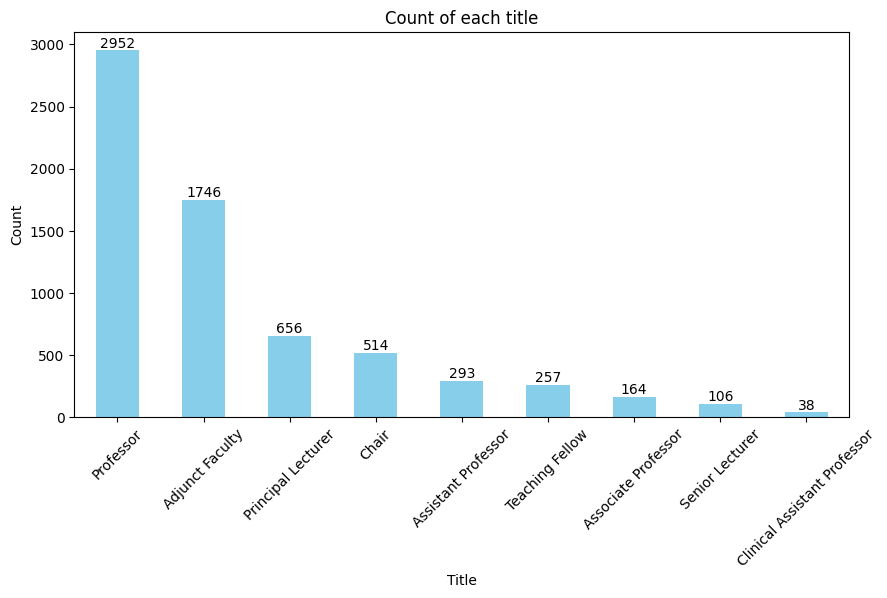

In [ ]:
uni_variate(req_data['title'].value_counts(),'Count of each title','Title','Count')

Total number of courses

In [ ]:
len(req_data['course'].unique())

294

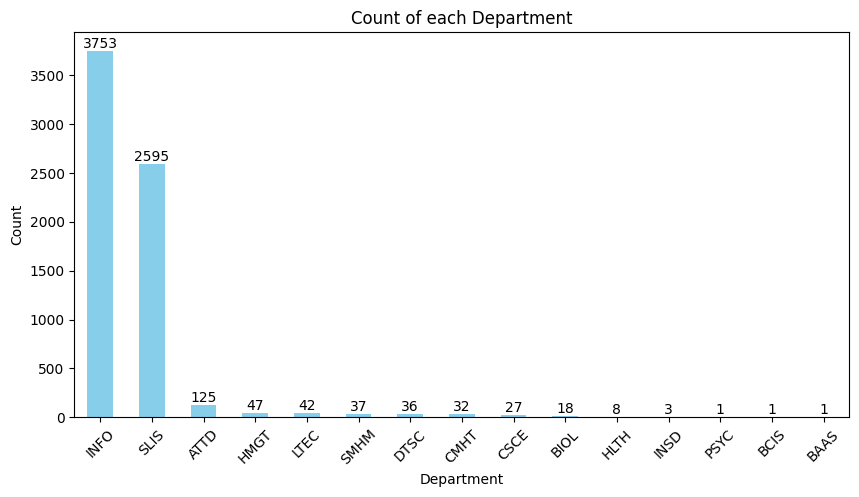

In [ ]:
uni_variate(req_data['course'].str[:4].value_counts(),'Count of each Department','Department','Count')

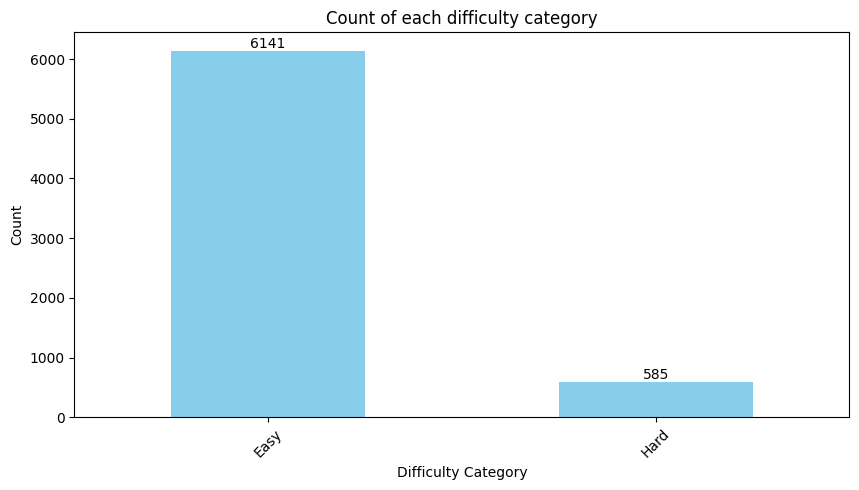

In [ ]:

uni_variate(req_data['Difficulty Category'].value_counts(),'Count of each difficulty category','Difficulty Category','Count')


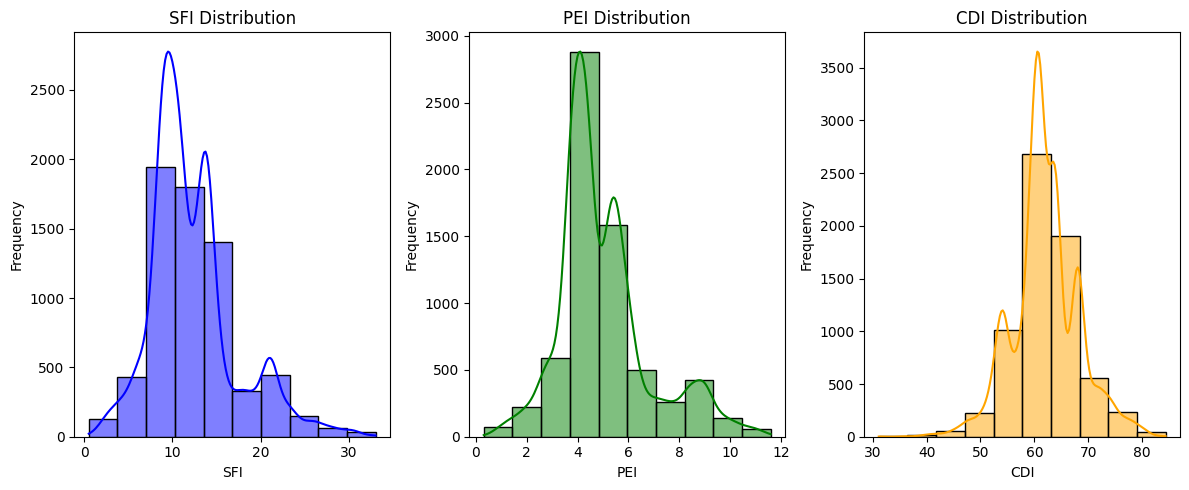

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
sns.histplot(req_data['SFI'], bins=10, kde=True, color='blue')
plt.title('SFI Distribution')
plt.xlabel('SFI')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
sns.histplot(req_data['PEI'], bins=10, kde=True, color='green')
plt.title('PEI Distribution')
plt.xlabel('PEI')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
sns.histplot(req_data['Course Difficulty Index'], bins=10, kde=True, color='orange')
plt.title('CDI Distribution')
plt.xlabel('CDI')
plt.ylabel('Frequency')


plt.tight_layout()
plt.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


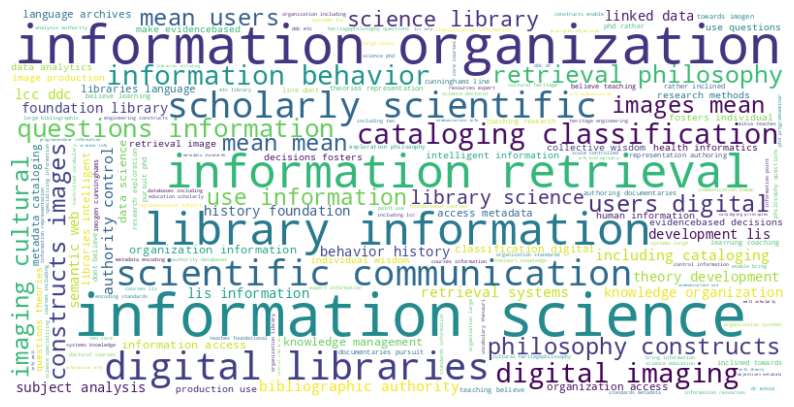

[('information', 14477), ('science', 4834), ('organization', 4114), ('library', 2854), ('digital', 2465), ('data', 2326), ('retrieval', 2200), ('metadata', 2179), ('knowledge', 1905), ('mean', 1828)]


In [ ]:
import nltk
from collections import Counter
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
import re

nltk.download('stopwords')

def clean_keywords(text):
    stop_words = set(stopwords.words('english'))
    filtered_words = [
        word for word in text.split()
        if word.lower() not in stop_words and ' ' not in word
    ]
    return ' '.join(filtered_words)

filtered_data = req_data[req_data['Keywords'] != 'Keywords not found']

keywords = ' '.join(
    filtered_data['Keywords']
    .apply(lambda x: ' '.join(x).lower() if isinstance(x, list) else x.lower())
    .dropna().astype(str)
)
keywords = re.sub(r'[^a-zA-Z\s]', '', keywords)
filtered_keywords = clean_keywords(keywords)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_keywords)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

keywords_list = filtered_keywords.split()
keywords_count = Counter(keywords_list)

print(keywords_count.most_common(10))


In [ ]:
text = list(req_data[req_data['name'] == 'Mohammed Aledhari']['Keywords'].head(1))


In [ ]:
flattened_data = ' '.join(text[0])

In [ ]:
flattened_data

'Artificial intelligence machine learning data science computer vision neuroscience and engineering sciences for computational medicine and biology bioinformatics biotechnology and healthcare domains especially . . investigating and identifying the features of certain genomic elements that regulate gene expression that aim to identify genes that cause diseases. .  particularly . . Cancer. .  . . Obesity. .  . . Aging. .  and . . Dementia. .and treat those diseases using justified evaluation metrics computationally and experimentally. . . Machine Learning Deep Learning A. rtificial intelligence Data Science Bioinformatics and Computer Vision... Artificial intelligence machine learning data science computer vision neuroscience and engineering sciences for computational medicine and biology bioinformatics biotechnology and healthcare domains especially investigating and identifying the features of certain genomic elements that regulate gene expression that aim to identify genes that cause

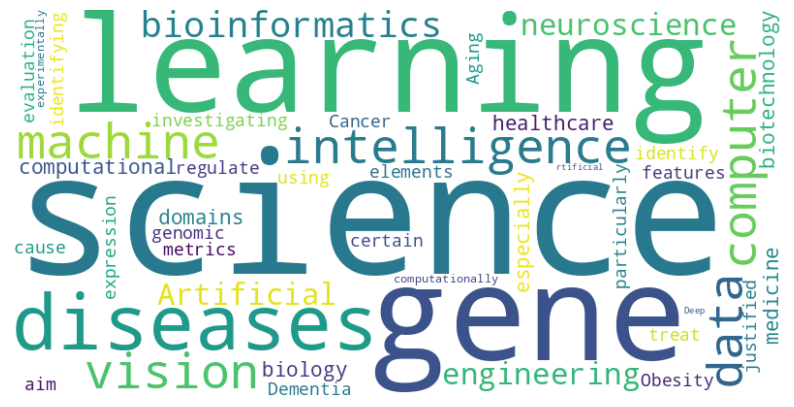

[('diseases', 4), ('intelligence', 3), ('Artificial', 2), ('machine', 2), ('learning', 2), ('data', 2), ('science', 2), ('computer', 2), ('vision', 2), ('neuroscience', 2)]


In [ ]:
flattened_data = re.sub(r'[^a-zA-Z\s]', '', flattened_data)
filtered_keywords = clean_keywords(flattened_data)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_keywords)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

keywords_list = filtered_keywords.split()
keywords_count = Counter(keywords_list)

print(keywords_count.most_common(10))
